# SDG&E Test System Data

This notebook is used to preprocess the data needed to create the San Diego test system model. Data manipulations performed in python to leverage `geopandas` library. 

In [1]:
import pandas as pd
import geopandas as gpd
import scipy.io 
import os
from os.path import join
import pylab as plt

# Path to each of the datasets
PATH = join(os.getcwd(), '..', 'data')
CATS = 'cats'
OPF = 'opf'

In [2]:
def read_csv(filename, subdir=CATS):
    '''
    Returns standardized dataframe
    '''
    df = pd.read_csv(join(PATH, subdir, filename))
    df = standardize(df)
    return df

def read_geocsv(filename):
    '''
    Read a dataset with Lat and Lon columns and 
    return a geopandas DataFrame with point geometries
    '''
    df = read_csv(filename)
    gdf = gpd.GeoDataFrame(df,
           geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
    return gdf

def read_mat(filename, columns, subdir=OPF):
    '''
    Read a MATLAB .mat file of a matrix 
    and return dataframe where each columns is labeled
    '''
    # Assume object has the same name as the file
    object_name = filename.split(".")[0]
    
    # Read data and place in dataframe
    path = join(PATH, subdir, filename)
    data = scipy.io.loadmat(path)[object_name]
    df = pd.DataFrame(data=data, columns=columns)
    df = standardize(df)
    return df

def standardize(df):
    '''
    Standardize dataframes to 1 indexed and 
    lowercase columns.
    '''
    # Adjust index to start at 1 not 0
    df.index += 1
    # Make all columns lowercase
    df.columns = [s.lower() for s in df.columns]
    return df

In [3]:
# Read each of the CATS datasets
buses = read_geocsv('buses.csv').rename(columns={'bus_i':'bus'})
gens = read_csv('generators.csv')
gens['id'] = gens.index # Add an index to generators

lines = (gpd
         .read_file(join(PATH, CATS, 'lines.json'))
         .pipe(standardize)
         .rename(columns={'cats_id':'id', 'br_r':'r', 'br_x':'x', 'br_b':'b'})
        )
lines = lines[~lines['transformer']] # Drop transformers from dataset

loads = read_csv('loads.csv').rename(columns={'bus_i':'bus'}).set_index('bus')

# Read OPF datasets (in base of 100MVA)
columns = ['model', 'startup', 'shutdown', 'n', 'c2', 'c1', 'c0']
gencost = read_mat('gencost.mat', columns)
# Add generator costs to the gens dataset
gens = gencost.join(gens)

# Read IOU shapefile and select SDG&E shape
ious = gpd.read_file(join(PATH, 'iou.geojson'))
sdge = ious[ious['Acronym'] == 'SDG&E'][['geometry']]

In [6]:
# Select all buses in SDG&E service area (to create a test system)
sd_buses = gpd.sjoin(buses, sdge).drop(columns='index_right')
bus_cols = ['bus', 'kv', 'type', 'geometry'] 
sd_buses = sd_buses[bus_cols]
bus_ids = set(sd_buses.index)

### Select all gens, lines, and loads in SDG&E area ###

# Select lines (only that start and end in SDG&E area)
line_cols = ['id', 'f_bus', 't_bus', 'r', 'x', 'b', 'rate_a', 'kv', 'geometry']
sd_lines = lines[(lines['f_bus'].isin(bus_ids) & lines['t_bus'].isin(bus_ids))]
sd_lines = sd_lines[line_cols]

# Add lines in the reverse direction
cpy = sd_lines.copy()
cpy['f_bus'], cpy['t_bus'] = cpy['t_bus'], cpy['f_bus']
sd_lines = pd.concat((sd_lines, cpy)).reset_index(drop=True)

# Remove any stray buses that are not connected by lines
bus_ids = set(sd_lines["f_bus"]) | set(sd_lines["t_bus"])
sd_buses = sd_buses[sd_buses["bus"].isin(bus_ids)]

# Lines and buses crossing the border 
import_lines = lines[(lines['f_bus'].isin(bus_ids) ^ lines['t_bus'].isin(bus_ids))]
import_buses = (set(import_lines[import_lines['f_bus'].isin(bus_ids)]['f_bus']) 
                | set(import_lines[import_lines['t_bus'].isin(bus_ids)]['t_bus']))

# Select generators (and only relevant columns)
gen_cols = ['id', 'bus', 'startup', 'shutdown', 'n', 'c2', 'c1', 'c0',  
        'fueltype', 'pg', 'pmax', 'pmin', 'qg', 'qmax', 'qmin']
sd_gens = gens[gens['bus'].isin(bus_ids)]
sd_gens = sd_gens[gen_cols].reset_index(drop=True)

# Add "import generators" with CATS parameters to any nodes with a 
# transmission line exiting the test system area
import_gens = gens[gens['fueltype'] == 'IMPORT'].head(len(import_buses)).copy()
import_gens = import_gens[gen_cols]
import_gens['bus'] = list(import_buses)
sd_gens = pd.concat((sd_gens, import_gens))

# Select loads (and convert to MW)
sd_loads = loads[loads.index.isin(bus_ids)] / 1000

# Select 24 hours of load from a representative week in each season
# Representative weeks are determined using k-means clustering on all load profiles
load_24h_sp = sd_loads.loc[:, slice("2018-04-02T01:00:00", "2018-04-03T01:00:00")]
load_24h_su = sd_loads.loc[:, slice("2018-08-11T01:00:00", "2018-08-12T01:00:00")]
load_24h_fa = sd_loads.loc[:, slice("2018-10-22T01:00:00", "2018-10-23T01:00:00")]
load_24h_wi = sd_loads.loc[:, slice("2018-12-07T01:00:00", "2018-12-08T01:00:00")]

In [7]:
# Save each of the San Deigo test system files in data directory 
sd_buses[bus_cols[:-1]].to_csv(join(PATH, "test_system", "buses.csv"), index=False)
sd_gens.to_csv(join(PATH, "test_system", "gens.csv"), index=False)
sd_lines[line_cols[:-1]].to_csv(join(PATH, "test_system", "lines.csv"), index=False)

# And each of the four 24h load profiles
load_24h_sp.to_csv(join(PATH, "test_system", "loads_24h_sp.csv"))
load_24h_su.to_csv(join(PATH, "test_system", "loads_24h_su.csv"))
load_24h_fa.to_csv(join(PATH, "test_system", "loads_24h_fa.csv"))
load_24h_wi.to_csv(join(PATH, "test_system", "loads_24h_wi.csv"))

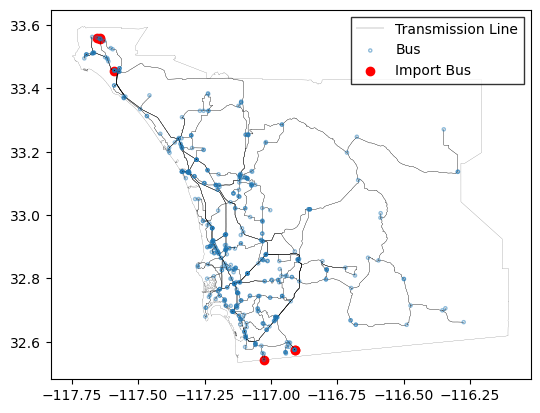

In [8]:
fig, ax = plt.subplots()
sd_lines.plot(ax=ax, color='k', lw=0.15, label="Transmission Line")
sd_buses.plot(ax=ax, zorder=2, alpha=0.5, facecolor='none', edgecolor='C0', markersize=5, label="Bus")
sdge.plot(ax=ax, facecolor='none', edgecolor='k', lw = 0.1)

buses[buses["bus"].isin(list(import_gens['bus']))].plot(color='r', ax=ax, label="Import Bus")
plt.legend(fancybox=False, edgecolor='k')
#plt.savefig("test_system.svg")